# Grouped Regression Data

> Data simulated with group effects, data is now correlated.

In [ ]:
#| default_exp synthetic_data.grouped_regression_data

In [ ]:
#| hide
from nbdev.showdoc import *
import pprint
from itertools import product
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pymc as pm
from tueplots import bundles
from tueplots.constants.color import rgb
import seaborn as sns

In [ ]:
#| hide
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#| export
#| hide
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xarray as xr
from typing import Optional

In [ ]:
#| export
def generate_grouped_data(
    sample_size: int, # Number of samples per group
    n_exogenous_vars: int, # Number of exogenous variables
    n_confounders: int = 0, # Number of confounder variables
    n_groups: int = 1, # Number of independent groups
    n_group_attributes: int = 0, # Number of group level attributes
    group_var: float = 3, # Variance between groups
    noise_sigma: float = 1, # Std of noise for each observation
    random_effect_assumption_satified: bool = True, # Is random effect assumption valid
    random_seed: Optional[int] = None
) -> xr.Dataset: # Synthetic dataset
    "Generate grouped regression data"
    # Input checks
    assert sample_size > 0, "Sample size must be positive"
    assert n_exogenous_vars > 0, "Number of exogenous variables must be positive"
    assert n_confounders >= 0, "Number of confounders must be positive or zero"
    assert n_groups > 0, "Number of groups must be positive"
    rng = np.random.default_rng(random_seed)
    group_names = [f"group_{i}" for i in range(n_groups)]
    exog_var_names = [f"var_{i}" for i in range(n_exogenous_vars)]
    confounder_names = []
    confounder_data = np.zeros(shape=(1, n_groups, sample_size))
    confounder_beta = np.zeros(shape=(n_exogenous_vars, 1))
    if n_confounders>0:
        confounder_names = [f"con_{i}" for i in range(n_confounders)]
        confounder_data = rng.normal(0, 1, size=(n_confounders, n_groups, sample_size))
        confounder_beta = rng.normal(0, 1, size=(n_exogenous_vars, n_confounders))
    
    group_var_offset = rng.normal(0, group_var, n_groups)
    group_confound = np.zeros_like(group_var_offset)

    if not random_effect_assumption_satified:
        group_confound = rng.normal(group_var_offset, .2, n_groups)

    exog_data = rng.normal(
        0, 1, 
        size=(n_exogenous_vars, n_groups, sample_size)
        )
    exog_data = exog_data + np.einsum('ij,jkl->ikl', confounder_beta, confounder_data)
    exog_data = exog_data + group_confound[None, :, None]
    
    exog_betas = rng.normal(0, 1, size=n_exogenous_vars)
    if n_confounders>0:
        confounder_beta = rng.normal(0, 1, size=n_confounders)
    
    dep_var = (
        np.einsum('i,ikl->kl', confounder_beta, confounder_data) 
        + np.einsum('i,ikl->kl', exog_betas, exog_data)
        + group_var_offset[..., None] + group_confound[..., None]
        + noise_sigma * rng.normal(0, 1, size=(n_groups, sample_size))
    )
    _index = np.arange(sample_size)
    variables = {}
    for i, var in enumerate(exog_var_names):
        variables[var] = xr.DataArray(
            exog_data[i], 
            coords={'group': group_names, 'index': _index},
            dims=('group', 'index')
        )
    for i, var in enumerate(confounder_names):
        variables[var] = xr.DataArray(
            confounder_data[i],
            coords={'group': group_names, 'index': _index},
            dims=('group', 'index')
        )
    variables['depvar'] = xr.DataArray(
        dep_var,
        coords={'group': group_names, 'index': _index},
        dims=('group', 'index')
    )
    dataset = xr.Dataset(variables)
    dataset = dataset.assign_attrs(
        true_alpha=group_var_offset[..., None] + group_confound[..., None],
        true_betas={var_name: np.round(exog_betas[i], 4) for i, var_name in enumerate(exog_var_names)})
    return dataset

    

In [ ]:
data = generate_grouped_data(100, 3, n_confounders=1, n_groups=5, random_seed=42, random_effect_assumption_satified=False)

In [ ]:
data.head()

<xarray.Dataset> Size: 1kB
Dimensions:  (group: 5, index: 5)
Coordinates:
  * group    (group) <U7 140B 'group_0' 'group_1' 'group_2' 'group_3' 'group_4'
  * index    (index) int64 40B 0 1 2 3 4
Data variables:
    var_0    (group, index) float64 200B -4.29 -5.247 -3.251 ... 2.224 2.565
    var_1    (group, index) float64 200B -6.002 -6.595 -4.969 ... 3.201 2.787
    var_2    (group, index) float64 200B -6.836 -5.554 -4.949 ... 0.9918 1.975
    con_0    (group, index) float64 200B 0.3047 -1.04 0.7505 ... -0.3937 0.5212
    depvar   (group, index) float64 200B -20.39 -19.84 -17.33 ... 6.005 7.054
Attributes:
    true_alpha:  [[ -9.12693519]\n [-17.69415699]\n [ -3.57316472]\n [ 14.463...
    true_betas:  {'var_0': -0.0102, 'var_1': 1.5902, 'var_2': 0.1593}

In [ ]:
df = data.to_dataframe().reset_index()
df_with_dummies = df.join(pd.get_dummies(df.group).astype(int))
df_with_dummies.head()

,group,index,var_0,var_1,var_2,con_0,depvar,group_0,group_1,group_2,group_3,group_4
0,group_0,0,-4.289933,-6.001742,-6.836129,0.304717,-20.385115,1,0,0,0,0
1,group_0,1,-5.247014,-6.595447,-5.553503,-1.039984,-19.835244,1,0,0,0,0
2,group_0,2,-3.251268,-4.968677,-4.949068,0.750451,-17.327917,1,0,0,0,0
3,group_0,3,-2.668298,-3.725272,-6.011019,0.940565,-15.993002,1,0,0,0,0
4,group_0,4,-7.968740,-6.639813,-1.903668,-1.951035,-20.642885,1,0,0,0,0


<seaborn.axisgrid.PairGrid>

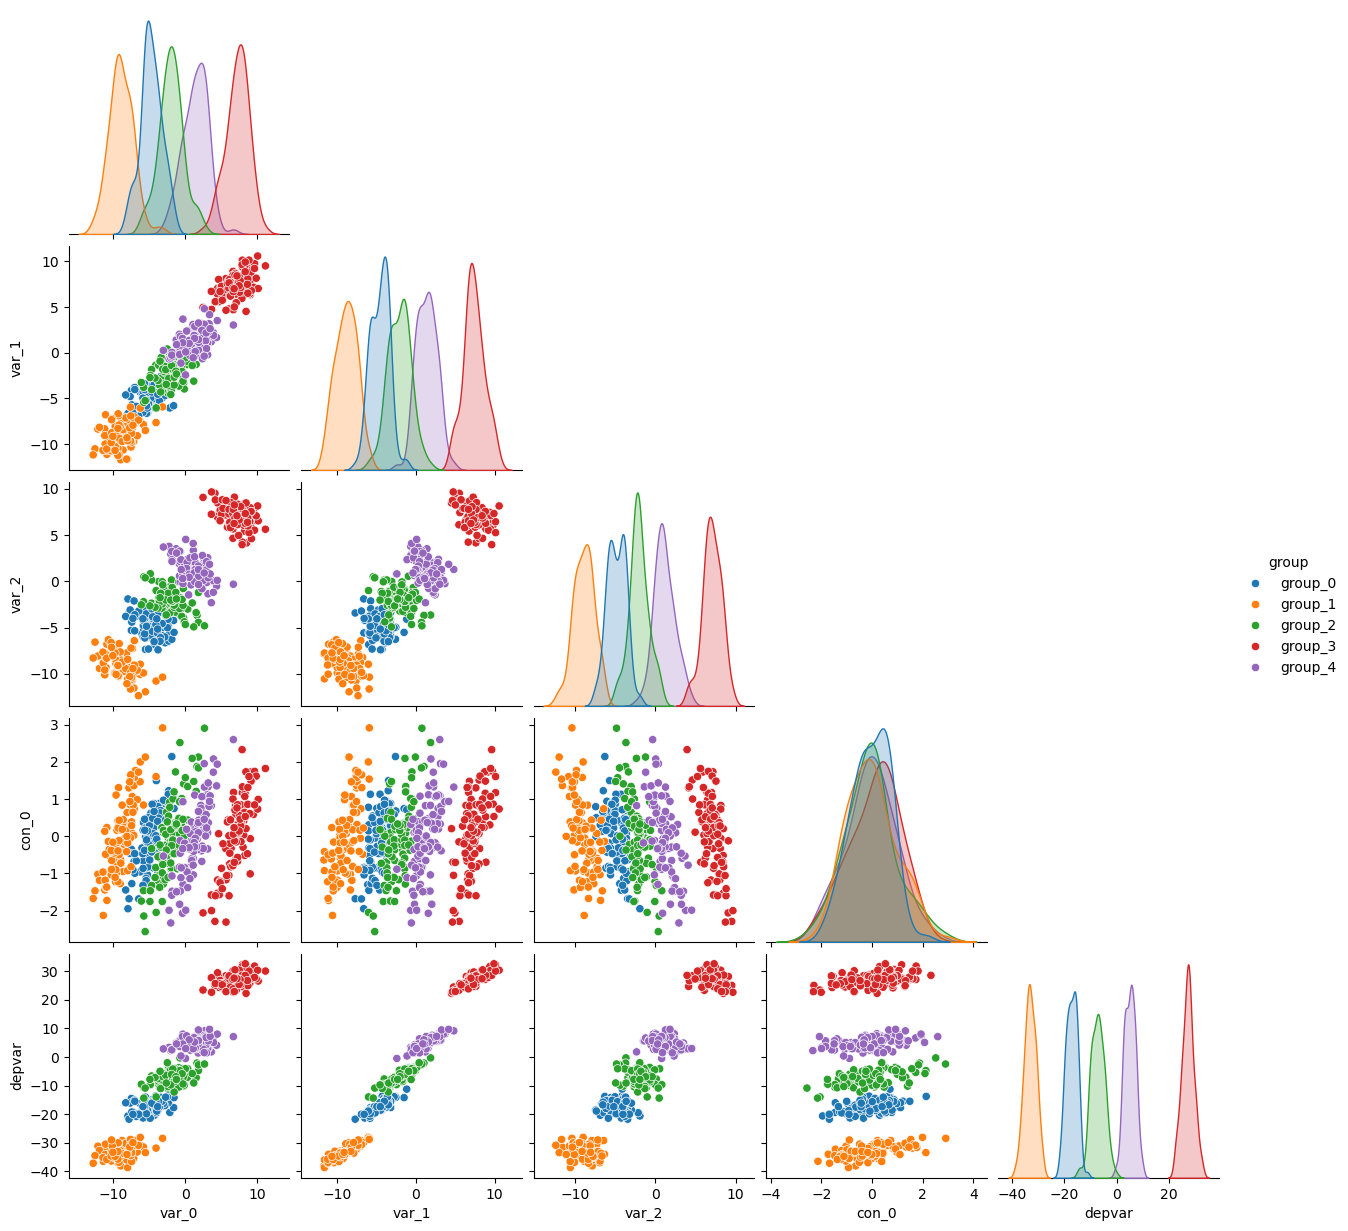

In [ ]:
sns.pairplot(df_with_dummies[['var_0', 'var_1', 'var_2', 'con_0', 'depvar', 'group']], hue='group', corner=True)

In [ ]:
cluster_model = sm.OLS(
    df_with_dummies['depvar'], 
    df_with_dummies[['group_0', 'group_1', 'group_2', 'group_3', 'group_4', 'var_0', 'var_1', 'var_2', 'con_0']]
    ).fit(
        cov_type='cluster', 
        cov_kwds={'groups': pd.factorize(df_with_dummies["group"])[0]}, use_t=True)
cluster_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 depvar   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 03 Nov 2024   Prob (F-statistic):                nan
Time:                        23:01:02   Log-Likelihood:                -714.05
No. Observations:                 500   AIC:                             1446.
Df Residuals:                     491   BIC:                             1484.
Df Model:                           8                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
group_0       -8.6226      0.297    -29.009      0.000      -9.448      -7.797
group_1      -16.5405      0.535    -30.937      0.000     -18.025     -15.056
group_2       -3.3568      0.124    -27.174      0.000      -3.700      -3.014
group_3       13.6005      0.424     32.043      0.000      12.422      14.779
group_4        2.5296      0.066     38.340      0.000       2.346       2.713
var_0          0.0602      0.029      2.107      0.103      -0.019       0.140
var_1          1.5980      0.028     57.342      0.000       1.521       1.675
var_2          0.2006      0.063      3.200      0.033       0.027       0.375
con_0         -0.1632      0.079     -2.075      0.107      -0.382       0.055
==============================================================================
Omnibus:                        1.163   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.559   Jarque-Bera (JB):                0.962
Skew:                          -0.062   Prob(JB):                        0.618
Kurtosis:                       3.176   Cond. No.                         221.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [ ]:
simple_ols_model = sm.OLS(
    df_with_dummies['depvar'], 
    sm.add_constant(df_with_dummies[['var_0', 'var_1', 'var_2', 'con_0']])
    ).fit(use_t=True)
simple_ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 depvar   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.412e+04
Date:                Sun, 03 Nov 2024   Prob (F-statistic):               0.00
Time:                        23:02:37   Log-Likelihood:                -900.38
No. Observations:                 500   AIC:                             1811.
Df Residuals:                     495   BIC:                             1832.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1839      0.069      2.683      0.008       0.049       0.319
var_0          0.7034      0.053     13.397      0.000       0.600       0.807
var_1          2.1893      0.052     41.741      0.000       2.086       2.292
var_2          0.8212      0.053     15.420      0.000       0.717       0.926
con_0         -1.0991      0.120     -9.138      0.000      -1.335      -0.863
==============================================================================
Omnibus:                        7.551   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                8.085
Skew:                          -0.222   Prob(JB):                       0.0176
Kurtosis:                       3.438   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
mean_adj = data - data.mean(dim='index')
df_demeaned = mean_adj.to_dataframe().reset_index()
df_demeaned_with_dummies = df_demeaned.join(pd.get_dummies(df_demeaned.group).astype(int))
df_demeaned_with_dummies.head()

,group,index,var_0,var_1,var_2,con_0,depvar,group_0,group_1,group_2,group_3,group_4
0,group_0,0,0.481425,-1.406211,-2.004544,0.354987,-3.170462,1,0,0,0,0
1,group_0,1,-0.475656,-1.999916,-0.721918,-0.989714,-2.620590,1,0,0,0,0
2,group_0,2,1.520091,-0.373147,-0.117483,0.800721,-0.113263,1,0,0,0,0
3,group_0,3,2.103060,0.870259,-1.179433,0.990834,1.221651,1,0,0,0,0
4,group_0,4,-3.197382,-2.044282,2.927917,-1.900766,-3.428232,1,0,0,0,0


In [ ]:
simple_ols_model_demeaned = sm.OLS(
    df_demeaned_with_dummies['depvar'], 
    (df_demeaned_with_dummies[['var_0', 'var_1', 'var_2', 'con_0']])
    ).fit(use_t=True)
simple_ols_model_demeaned.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 depvar   R-squared (uncentered):                   0.795
Model:                            OLS   Adj. R-squared (uncentered):              0.793
Method:                 Least Squares   F-statistic:                              481.0
Date:                Sun, 03 Nov 2024   Prob (F-statistic):                   3.90e-169
Time:                        23:08:16   Log-Likelihood:                         -714.05
No. Observations:                 500   AIC:                                      1436.
Df Residuals:                     496   BIC:                                      1453.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
var_0          0.0602      0.046      1.322      0.187      -0.029       0.150
var_1          1.5980      0.044     36.038      0.000       1.511       1.685
var_2          0.2006      0.045      4.421      0.000       0.111       0.290
con_0         -0.1632      0.092     -1.766      0.078      -0.345       0.018
==============================================================================
Omnibus:                        1.163   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.559   Jarque-Bera (JB):                0.962
Skew:                          -0.062   Prob(JB):                        0.618
Kurtosis:                       3.176   Cond. No.                         4.73
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
simple_ols_model_demeaned = sm.OLS(
    df_demeaned_with_dummies['depvar'], 
    (df_demeaned_with_dummies[['var_0', 'var_1', 'var_2', 'con_0']])
    ).fit(cov_type='cluster', cov_kwds={'groups': df_demeaned_with_dummies['group']}, use_t=True)
simple_ols_model_demeaned.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 depvar   R-squared (uncentered):                   0.795
Model:                            OLS   Adj. R-squared (uncentered):              0.793
Method:                 Least Squares   F-statistic:                          3.833e+04
Date:                Sun, 03 Nov 2024   Prob (F-statistic):                    2.04e-09
Time:                        23:07:12   Log-Likelihood:                         -714.05
No. Observations:                 500   AIC:                                      1436.
Df Residuals:                     496   BIC:                                      1453.
Df Model:                           4                                                  
Covariance Type:              cluster                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
var_0          0.0602      0.028      2.118      0.102      -0.019       0.139
var_1          1.5980      0.028     57.633      0.000       1.521       1.675
var_2          0.2006      0.062      3.217      0.032       0.027       0.374
con_0         -0.1632      0.078     -2.085      0.105      -0.380       0.054
==============================================================================
Omnibus:                        1.163   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.559   Jarque-Bera (JB):                0.962
Skew:                          -0.062   Prob(JB):                        0.618
Kurtosis:                       3.176   Cond. No.                         4.73
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are robust to cluster correlation (cluster)
"""

In [ ]:
simple_ols_model_demeaned_depvar = sm.OLS(
    df_demeaned_with_dummies['depvar'], 
    (df_with_dummies[['group_0', 'group_1', 'group_2', 'group_3', 'group_4','var_0', 'var_1', 'var_2', 'con_0']])
    ).fit(cov_type='cluster', cov_kwds={'groups': df_demeaned_with_dummies['group']}, use_t=True)
simple_ols_model_demeaned_depvar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 depvar   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 03 Nov 2024   Prob (F-statistic):                nan
Time:                        23:10:36   Log-Likelihood:                -714.05
No. Observations:                 500   AIC:                             1446.
Df Residuals:                     491   BIC:                             1484.
Df Model:                           8                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
group_0        8.5920      0.297     28.907      0.000       7.767       9.417
group_1       16.5130      0.535     30.886      0.000      15.029      17.997
group_2        3.9143      0.124     31.687      0.000       3.571       4.257
group_3      -13.5953      0.424    -32.031      0.000     -14.774     -12.417
group_4       -2.4543      0.066    -37.198      0.000      -2.637      -2.271
var_0          0.0602      0.029      2.107      0.103      -0.019       0.140
var_1          1.5980      0.028     57.342      0.000       1.521       1.675
var_2          0.2006      0.063      3.200      0.033       0.027       0.375
con_0         -0.1632      0.079     -2.075      0.107      -0.382       0.055
==============================================================================
Omnibus:                        1.163   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.559   Jarque-Bera (JB):                0.962
Skew:                          -0.062   Prob(JB):                        0.618
Kurtosis:                       3.176   Cond. No.                         221.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [ ]:
smf.mixedlm('depvar ~ var_0 + var_1 + var_2 + con_0', data=df_with_dummies, groups=df_with_dummies['group']).fit(method=["lbfgs"]).summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: depvar   
No. Observations: 500     Method:             REML     
No. Groups:       5       Scale:              1.0373   
Min. group size:  100     Log-Likelihood:     -745.7758
Max. group size:  100     Converged:          Yes      
Mean group size:  100.0                                
-------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------
Intercept   -2.458    5.051 -0.487 0.627 -12.358  7.443
var_0        0.065    0.046  1.419 0.156  -0.025  0.155
var_1        1.602    0.045 35.910 0.000   1.515  1.690
var_2        0.205    0.046  4.495 0.000   0.116  0.295
con_0       -0.170    0.093 -1.832 0.067  -0.352  0.012
Group Var  127.501   89.028                            
=======================================================

"""

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()